In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn
from collections import Counter


In [2]:
chat = pd.read_csv('data/transcripts/SBC001.trn',header=None)
chat.head()

,0,1
0,0.00 9.21\tLENORE: \t... So you don't need to ...,NaN
1,9.21 9.52\t \tto --,NaN
2,9.52 14.10\t \t... to do the feet?,NaN
3,14.10 15.78\t \t... [Do the hooves]?,NaN
4,15.01 16.78\tLYNNE: \t [(H)=] <YWN Well,NaN


In [3]:
def process_chat(file_path):
    #print file_path
    chat = []
    with open(file_path) as f:
        for line in f:
            chat.append(line.strip().split('\t'))

    if int(file_path[21:23])<14:
        chat[:] = [line for line in chat if len(line)==3] #delete comments
        # separate end and start times
        for i,line in enumerate(chat):
            chat[i] = chat[i][0].split() + line[1:] 
            m = re.search(':',chat[i][2])
            if m:
                chat[i][2] = chat[i][2][:m.start()]
            else:
                chat[i][2] = chat[i-1][2]
    else:
        chat[:] = [line for line in chat if len(line)==4]
    
    chat = pd.DataFrame(chat)
    chat.columns = ['start_time','end_time','person','speech']
    
    # clean speech
    chat['clean_speech'] = chat.speech #placeholder
    for i,text in enumerate(chat.clean_speech):
        text = text.lower()
        text = re.sub(r'\[.*\]|\(.*\)|=|x+($|[^a-z\-])|--+|\w*>', '', text) #[] denotes people talking over each other.
        text = re.sub(r'[^a-z\'\-]',' ',text)       
        chat.clean_speech[i] = text.split()
    return chat

In [4]:
def get_list_of_words(clean_speech_series):
    """get list of words from time series of clean speech"""    
    words = []
    for text in clean_speech_series:
        words = words + text 
    return words

In [5]:
def find_bigrams(input_list):
  return zip(input_list, input_list[1:])

In [6]:
def get_list_of_bigrams(clean_speech_series):
    """get list of bigrams from all the sentences in clean speech"""
    bigrams = []
    for sentence in clean_speech_series:
        bigrams = bigrams + find_bigrams(sentence)
    return bigrams    

In [7]:
#create a dictionary with all the words
chat1 = process_chat('data/transcripts/SBC001.trn')
word_dict = Counter(get_list_of_words(chat1.clean_speech))
bigram_dict = Counter(get_list_of_bigrams(chat1.clean_speech))

file_names = os.listdir('data/transcripts')
for file_name in file_names[1:] :    
    chat = process_chat('data/transcripts/'+file_name)
    word_dict.update(get_list_of_words(chat.clean_speech))
    bigram_dict.update(get_list_of_bigrams(chat.clean_speech))

In [8]:
# get most common words and counts for bar graph
mc_words = []
mc_counts = []
for word_and_count in word_dict.most_common(30):
    mc_words.append(word_and_count[0])
    mc_counts.append(word_and_count[1])
    
mc_bigrams = []
mc_bigram_counts = []
for bigram_and_count in bigram_dict.most_common(20):
    mc_bigrams.append(bigram_and_count[0][0] + ' ' + bigram_and_count[0][1])
    mc_bigram_counts.append(bigram_and_count[1])

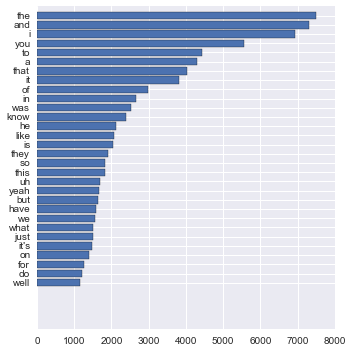

In [12]:
X = np.arange(len(mc_words))
h_bar = plt.barh(X, mc_counts[-1::-1], align='center')
plt.yticks(X, mc_words[-1::-1]);
plt.rcParams["figure.figsize"] = [5,5]
plt.tight_layout()
plt.savefig('/Users/lfjover/lfjover.github.io/figures/common_words.png',dpi = 300)


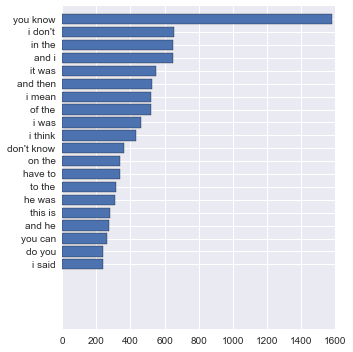

In [10]:
X = np.arange(len(mc_bigrams))
h_bar = plt.barh(X, mc_bigram_counts[-1::-1], align='center')
plt.yticks(X, mc_bigrams[-1::-1]);
plt.rcParams["figure.figsize"] = [5,5]
plt.tight_layout()
plt.savefig('/Users/lfjover/lfjover.github.io/figures/common_bigrams.png',dpi = 300)
